<a href="https://colab.research.google.com/github/Leo166/gbio_project/blob/main/Projet_gbio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

------------------
## **Characterisation of the sensor inputs**
-----------------

1.0


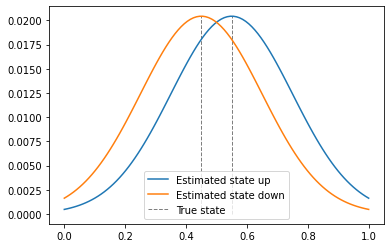

0.040866841132262965


In [ ]:
# Function to generate the gaussian probabilities of a vector x
# Parameter: x - numpy array - numbers where to evaluate the distribution
#            mean - float - mean of of the normal distribution
#            strd - float - standard deviation of the normal distribution
# Return: the probabilities at x
def gaussian_distribution(x, mean, strd):
  prob = (1/np.sqrt(2*np.pi*strd**2)) * np.exp(- 0.5/strd**2 * (mean - x) ** 2)
  prob = prob / prob.sum()
  return prob

mean_up = 0.55
strd_up = 0.2
mean_down = 0.45
strd_down = 0.2
x = np.linspace(-0,1,100)

# True and estmated state of the arrow up
p_up = gaussian_distribution(x, mean_up, strd_up)
# True and estmated state of the arrow down
p_down = gaussian_distribution(x, mean_down, strd_down)

print(np.sum(p_up))
plt.plot(x, p_up, color="C0", label='Estimated state up')
plt.vlines(mean_up, 0, np.max(p_up), colors='C7', linestyles='dashed', label='True state', linewidth=1)
plt.plot(x, p_down, color="C1", label='Estimated state down')
plt.vlines(mean_down, 0, np.max(p_down), colors='C7', linestyles='dashed', linewidth=1)
plt.legend()
plt.show()
print((np.max(p_up)/2)/0.25)

--------------
## **Sequential probability ratio test (SPRT) - Decision making**
---------------

**Distribution of the likelihood and log-likelihood ratio**

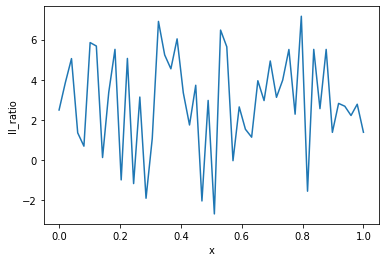

In [ ]:
# Function to generate the sensor inputs
def normal_ll_ratio(sensor_inputs, mean_down, mean_up, strd_down, strd_up):
  ll_ratio = np.log(strd_down/strd_up) + 0.5 * (sensor_inputs-mean_down)**2/(strd_down)**2 - 0.5 * (sensor_inputs-mean_up)**2/(strd_up)**2
  return ll_ratio


#plot  
mean_down = 0.25
mean_up = 0.75
strd_down = 0.2
strd_up = 0.2
nbr_trials = 50
rv_up = norm(loc=mean_up,scale=strd_up)
sensor_inputs = rv_up.rvs(size=nbr_trials)
ll_ratio = normal_ll_ratio(sensor_inputs, mean_down, mean_up, strd_down, strd_up)
x = np.linspace(0, 1, 50)
plt.plot(x, ll_ratio) 
plt.xlabel("x") 
plt.ylabel("ll_ratio") 
  
plt.show() 

In [ ]:
#Use different likelihood - lineaire
def linear_ll_ration(real_state_up, real_state_down):
#  linearUp = m*x + p --> m = (dy/dx) jsp par quelles pts la faire passer 

In [ ]:
def sigmoid_ll_ratio(sensor_inputs):
  

**Decision making**

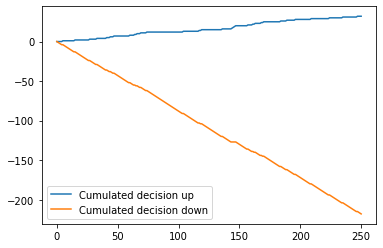

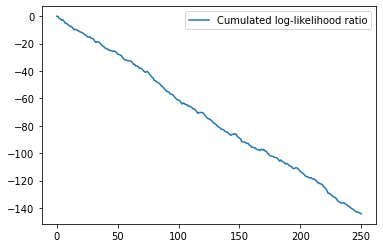

In [ ]:
# Function to generate the sensor inputs
# Parameter: strd_up - float - standard deviation of the up distribution
#            strd_down - float - the standard deviation of the down distribution
#            real_direction - boolean - real direction is up(1) or down(0)
#            nbr_trials - interger - number times the experience is repeated
# Return: sensory inputs - numpy array
def sensor_inputs_generator(strd_down, strd_up, real_direction, nbr_trials):
  mean_up = 0.75
  mean_down = 0.25

  rv_up = norm(loc=mean_up,scale=strd_up)
  rv_down = norm(loc=mean_down,scale=strd_down)
  if real_direction == 1:
    sensor_inputs = rv_up.rvs(size=nbr_trials)
  else:
    sensor_inputs = rv_down.rvs(size=nbr_trials)

  return sensor_inputs

# Function to performs the probability ratio test
# Inputs : strd_up is the standard deviation of the up distribution
#          strd_down is the standard deviation of the down distribution
#          real_direction is a binary variable telling us if the real direction is up(1) or down(0)
# Output : ll_ratio
#          decision 0(down) or 1(up)
def decision_making(strd_down,strd_up,real_direction):
  mean_up = 0.55
  mean_down = 0.45
  x = np.linspace(0,1,100)

  sensor_inputs = sensor_inputs_generator(strd_down, strd_up, real_direction, 250)

  ll_ratio = normal_ll_ratio(sensor_inputs,mean_down, mean_up, strd_down, strd_up)
  decision_up = [0]
  decision_down = [0]
  decision = [0]
  for i in ll_ratio:
    decision.append(decision[-1] + i)
    if i > 0:
      decision_up.append(decision_up[-1]+1)
      decision_down.append(decision_down[-1])
    elif i < 0:
      decision_up.append(decision_up[-1])
      decision_down.append(decision_down[-1]+1)
    # else:  Pas sûr qu'il aie besoin de le mettre
    # decision = np.random.randint(2)

  return np.array(decision_up), np.array(decision_down), np.array(decision)

strd_down = 0.2
strd_up = 0.2
decision_up, decision_down, decision = decision_making(strd_down, strd_up, 0)

plt.plot(range(len(decision_up)), decision_up, color="C0", label='Cumulated decision up')
plt.plot(range(len(decision_up)), -1*decision_down, color="C1", label='Cumulated decision down')
plt.legend()
plt.show()

plt.plot(range(len(decision)), decision, color="C0", label='Cumulated log-likelihood ratio')
plt.legend()
plt.show()

*   rester dans le domaine [0, 1]
*   likelihood: sigmoid, linéaire, polynome
*   discrétisation "forcée" f des distributions <-> variance dépend de n
*   Faire des expériences
*   creation prior
*   Multivariate gaussian (distance entre les flèches)




-Les décisions étaient inversées aussi du coup j'ai changé dans la formule du ll_ratio pour que ça corresponde

-Nombre de trial ce serait genre le nombre de fois que ça clignote si je comprend bien

-Reste encore à trouver une dépendance de strd avec le nombre de flèches montrées

Je pense que c'est représentatif là et interpretable. Si on augmente les strd, je prend comme exemple strd_up=strd_down=0.5 et je fais 50 trials tout en disant que la réponse est 0(down). On peut voir certaines fois qu'après genre 10 trials la décision n'est pas encore claire, la ligne bleu passe un petit coup au dessus de la orange, ce qui pour moi signifie qu'il est plus chaud de choisir le bleu que le orange si on s'arrete là. Evidemment puisqu'on prend des valeurs random, parfois la décision est directement très bien prise et reste la bonne tout le temps mais parfois on pourrait dire que le singe est susceptible de se tromper.

---------------
# **Analysis of the model**
---------------

0.9999999999999999


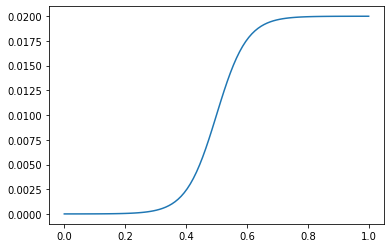

In [ ]:
mu = 0.75
s = 0.05
x = np.linspace(0, 1, 100) 
prob = 1/(1 + np.exp(-(x-mu)/s)) #probabilité
prob = prob / prob.sum()
print(np.sum(prob))

plt.plot(x, prob)

plt.show() 